In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
warnings.filterwarnings('ignore')
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
data = pd.read_csv('Taxi.4.csv', index_col=0, parse_dates=True)

In [3]:
regions=pd.read_csv('regions.csv', sep=';')
regions.index=regions.region
regions.drop(['region'], axis=1, inplace=True)

In [658]:
for i in range(1, 6):
    data[f'w_s{i}']=np.sin(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)
    data[f'w_c{i}']=np.cos(np.arange(1, data.shape[0]+1, 1)*2*np.pi*i/168)

#### Прогнозы SARIMAX на все часы с 01.01.2016-30.06.2016

In [659]:
E=pd.read_csv('sarima.csv')

## Дополнительные факторы

#### После анализа множества вариантов, я решил остановиться на добавлении следующих факторов:
#### 1) Праздники

In [660]:
party=['2016-01-01', '2016-01-18', '2016-02-14', '2016-02-15', '2016-03-17', '2016-03-27', '2016-05-30', '2016-06-14']

In [661]:
party_days=pd.to_datetime(party)

In [662]:
party_days_f=[]
party_days_f.extend([pd.date_range(i, i+pd.Timedelta(hours=23), freq='1h').values for i in party_days])

#### 2) Факторы, связанные с поездками из соседних географических зон (окрестность это номер ячейки -51,-50,-49,-1,+1,+49,+50,+51 ячейки)

#### 3) Создадим также признаки, отвечающие за количество поездок из зоны 23 ч./46 ч. назад, 22 ч./44 ч. назад итд.

т.е. чтобы для предсказания 16 часов одного дня была информация о количестве поездок в 16 часов прошлого дня

## Выборка для t+1

In [734]:
%%time
tim=1
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(l*24)
    for e in range(1,3):
        q[f'trips_-{e*23}h']=data[i].shift(e*23)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    q['neighbors']=0
    for h in [-49,-50,-51,-1,1,49,50,51]:
        if str(int(i)+h) in data.columns:
            q['neighbors']+=data[f'{(int(i)+h)}']
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-1)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()

#добавим праздники
partys=pd.Series(0, index=new_data.index)
for dt in party_days_f:
    partys.loc[dt]=1
new_data['partys']=partys
new_data.dropna(inplace=True)

CPU times: user 1min 45s, sys: 3.27 s, total: 1min 48s
Wall time: 1min 48s


In [735]:
data1=new_data.copy()
train_data_1=data1.loc['2016-01-02':'2016-04-30']
val_data_1=data1.loc['2016-05-01':'2016-05-31']

### В качестве регрессора будем использовать CatBoostRegressor

#### Осуществим подбор гиперпараметров по маю 2016 года

In [736]:
from catboost import CatBoostRegressor

In [737]:
from sklearn.metrics import mean_squared_error

In [738]:
from hyperopt import fmin, tpe, hp

In [739]:
#Столбцы с категориальными признаками (зона, день недели, час)
cat_features=[11,12,13,18]

In [807]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_1.drop(columns=['y']), train_data_1.y, cat_features)
    preds=cat.predict(val_data_1.drop(columns=['y']))
    return mean_squared_error(val_data_1.y, preds)

In [808]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [809]:
best=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [23:39<00:00, 14.19s/trial, best loss: 963.0009046644141]


In [810]:
print(best)

{'depth': 6, 'iterations': 265, 'learning_rate': 0.48911481778330385}


### Посмотри на графике:

In [811]:
mse_train=pd.Series()
mse_test=pd.Series()
for i in np.linspace(0.1,1,10):
    cat=CatBoostRegressor(learning_rate = i, depth = 6, iterations = 265, silent=True)
    cat.fit(train_data_1.drop(columns=['y']), train_data_1.y, cat_features)
    preds_train=cat.predict(train_data_1.drop(columns=['y']))
    preds_test=cat.predict(val_data_1.drop(columns=['y']))
    mse_train[i]=mean_squared_error(train_data_1.y, preds_train)
    mse_test[i]=mean_squared_error(val_data_1.y, preds_test)

In [812]:
MSE=pd.concat([mse_train, mse_test], axis=1)
MSE.columns=['train', 'test']

<AxesSubplot:>

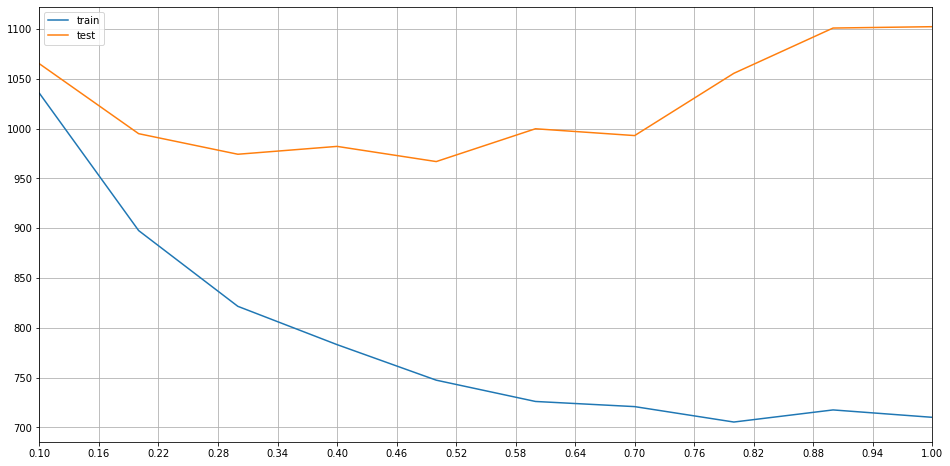

In [813]:
MSE.plot(legend=True, grid=True, figsize=(16,8), xticks=np.linspace(0.1,1,16))

In [814]:
cat1=CatBoostRegressor(**best, silent=True)
cat1.fit(train_data_1.drop(columns=['y']), train_data_1.y, cat_features)
preds=cat1.predict(val_data_1.drop(columns=['y']))

In [815]:
val_data_1['preds']=preds

<AxesSubplot:>

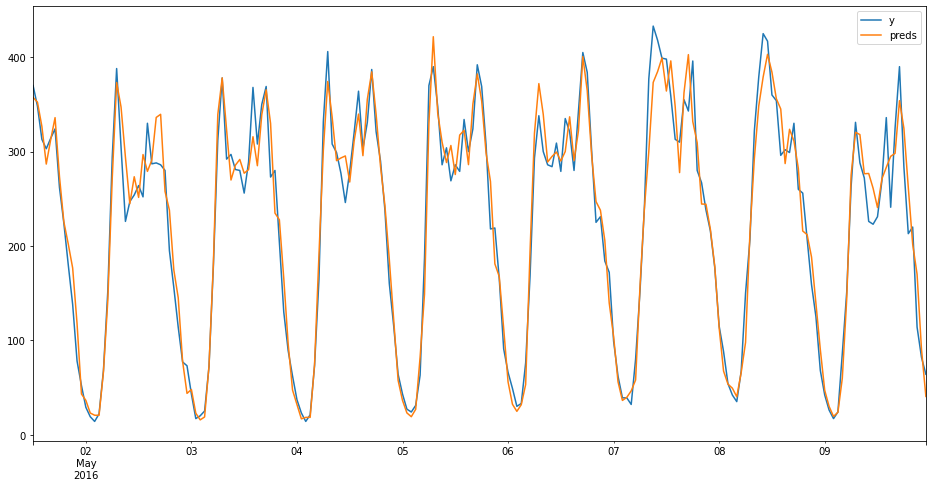

In [816]:
(val_data_1[['y', 'preds']][val_data_1.zone=='1286']).loc['2016-05-01 12:00':'2016-05-09 23:00'].plot(figsize=(16,8))

#### Невероятноя точность предсказаний на час вперед по валидационной выборке

In [817]:
train_data_1.columns[np.argsort(cat.feature_importances_)[::-1][:4]]

Index(['sar', 'trips', 'trips_-23h', 'trips_-4h'], dtype='object')

### Самые значимые признаки: Sarima, trips, trips-23h, trips-4h

## Выборка для t+2

In [759]:
%%time
tim=2
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(l*24)
    for e in range(1,3):
        q[f'trips_-{e*22}h']=data[i].shift(e*22)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    q['neighbors']=0
    for h in [-49,-50,-51,-1,1,49,50,51]:
        if str(int(i)+h) in data.columns:
            q['neighbors']+=data[f'{(int(i)+h)}']
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-2)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()

#добавим праздники
partys=pd.Series(0, index=new_data.index)
for dt in party_days_f:
    partys.loc[dt]=1
new_data['partys']=partys
new_data.dropna(inplace=True)

CPU times: user 1min 45s, sys: 2.08 s, total: 1min 47s
Wall time: 1min 47s


In [760]:
data2=new_data.copy()
train_data_2=data2.loc['2016-01-02':'2016-04-30']
val_data_2=data2.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [761]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_2.drop(columns=['y']), train_data_2.y, cat_features)
    preds=cat.predict(val_data_2.drop(columns=['y']))
    return mean_squared_error(val_data_2.y, preds)

In [762]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,250)
}

In [763]:
best1=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=30)

100%|██████████| 30/30 [07:53<00:00, 15.80s/trial, best loss: 1550.1160393584557]


In [764]:
print(best1)

{'depth': 6, 'iterations': 218, 'learning_rate': 0.3085361935469607}


In [765]:
cat2=CatBoostRegressor(**best1, silent=True)

## Выборка для t+3

In [766]:
%%time
tim=3
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(l*24)
    for e in range(1,3):
        q[f'trips_-{e*21}h']=data[i].shift(e*21)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    q['neighbors']=0
    for h in [-49,-50,-51,-1,1,49,50,51]:
        if str(int(i)+h) in data.columns:
            q['neighbors']+=data[f'{(int(i)+h)}']
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-3)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()

#добавим праздники
partys=pd.Series(0, index=new_data.index)
for dt in party_days_f:
    partys.loc[dt]=1
new_data['partys']=partys
new_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 1min 46s, sys: 2.33 s, total: 1min 48s
Wall time: 1min 48s


In [767]:
data3=new_data.copy()
train_data_3=data3.loc['2016-01-02':'2016-04-30']
val_data_3=data3.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [768]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_3.drop(columns=['y']), train_data_3.y, cat_features)
    preds=cat.predict(val_data_3.drop(columns=['y']))
    return mean_squared_error(val_data_3.y, preds)

In [769]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [770]:
best2=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:16<00:00, 15.16s/trial, best loss: 1795.1603010420213]


In [771]:
print(best2)

{'depth': 6, 'iterations': 255, 'learning_rate': 0.3666674138400161}


In [772]:
cat3=CatBoostRegressor(**best2, silent=True)

## Выборка для t+4

In [773]:
%%time
tim=4
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(l*24)
    for e in range(1,3):
        q[f'trips_-{e*20}h']=data[i].shift(e*20)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    q['neighbors']=0
    for h in [-49,-50,-51,-1,1,49,50,51]:
        if str(int(i)+h) in data.columns:
            q['neighbors']+=data[f'{(int(i)+h)}']
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-4)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()

#добавим праздники
partys=pd.Series(0, index=new_data.index)
for dt in party_days_f:
    partys.loc[dt]=1
new_data['partys']=partys
new_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 1min 45s, sys: 3.26 s, total: 1min 48s
Wall time: 1min 48s


In [774]:
data4=new_data.copy()
train_data_4=data4.loc['2016-01-02':'2016-04-30']
val_data_4=data4.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [775]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_4.drop(columns=['y']), train_data_4.y, cat_features)
    preds=cat.predict(val_data_4.drop(columns=['y']))
    return mean_squared_error(val_data_4.y, preds)

In [776]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [777]:
best3=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:47<00:00, 15.48s/trial, best loss: 1948.1109073856392]


In [778]:
print(best3)

{'depth': 6, 'iterations': 253, 'learning_rate': 0.466233520083901}


In [779]:
cat4=CatBoostRegressor(**best3, silent=True)

## Выборка для t+5

In [780]:
%%time
tim=5
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(l*24)
    for e in range(1,3):
        q[f'trips_-{e*19}h']=data[i].shift(e*19)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    q['neighbors']=0
    for h in [-49,-50,-51,-1,1,49,50,51]:
        if str(int(i)+h) in data.columns:
            q['neighbors']+=data[f'{(int(i)+h)}']
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-5)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()

#добавим праздники
partys=pd.Series(0, index=new_data.index)
for dt in party_days_f:
    partys.loc[dt]=1
new_data['partys']=partys
new_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 1min 45s, sys: 3.28 s, total: 1min 49s
Wall time: 1min 48s


In [781]:
data5=new_data.copy()
train_data_5=data5.loc['2016-01-02':'2016-04-30']
val_data_5=data5.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [782]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_5.drop(columns=['y']), train_data_5.y, cat_features)
    preds=cat.predict(val_data_5.drop(columns=['y']))
    return mean_squared_error(val_data_5.y, preds)

In [783]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [784]:
best4=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:53<00:00, 15.54s/trial, best loss: 2057.032063660499]


In [785]:
print(best4)

{'depth': 6, 'iterations': 266, 'learning_rate': 0.5726131556080045}


In [786]:
cat5=CatBoostRegressor(**best4, silent=True)

## Выборка для t+6

In [787]:
%%time
tim=6
new_data=pd.DataFrame()
for i in data.columns[:-10]:
    q=pd.DataFrame(data[i].values, index=data.index, columns=['trips'])
    for j in range(1,7):
        q[f'trips_-{j}h']=data[i].shift(j)
    for l in range(1,3):
        q[f'trips_-{l*24}h']=data[i].shift(l*24)
    for e in range(1,3):
        q[f'trips_-{e*18}h']=data[i].shift(e*18)
    q['zone']=i
    q['day_of_week']=q.index.dayofweek
    q['hour']=q.index.hour
    q['neighbors']=0
    for h in [-49,-50,-51,-1,1,49,50,51]:
        if str(int(i)+h) in data.columns:
            q['neighbors']+=data[f'{(int(i)+h)}']
    sar=E[E.id.str.endswith(f'{tim}') & E.id.str.startswith(i)]
    sar.index=pd.to_datetime(sar.id.str.replace(r'\d{4,}_', '').str.replace(r'_\d\b', ''), format='%Y-%m-%d_%H')
    sar.drop(columns=['id'], inplace=True)
    q['sar']=sar
    q['cumsum_12h']=q.trips.rolling('12h').sum()
    q['cumsum_24h']=q.trips.rolling('24h').sum()
    q['y']=data[i].shift(-6)
    new_data=pd.concat([new_data, q])
new_data=new_data.sort_index()

#добавим праздники
partys=pd.Series(0, index=new_data.index)
for dt in party_days_f:
    partys.loc[dt]=1
new_data['partys']=partys
new_data.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


CPU times: user 1min 46s, sys: 3.18 s, total: 1min 49s
Wall time: 1min 49s


In [788]:
data6=new_data.copy()
train_data_6=data6.loc['2016-01-02':'2016-04-30']
val_data_6=data6.loc['2016-05-01':'2016-05-31']

#### Осуществим подбор гиперпараметров по маю 2016 года

In [789]:
def reg(params):
    cat=CatBoostRegressor(**params, silent=True)
    cat.fit(train_data_6.drop(columns=['y']), train_data_6.y, cat_features)
    preds=cat.predict(val_data_6.drop(columns=['y']))
    return mean_squared_error(val_data_6.y, preds)

In [790]:
space={'depth':hp.randint('depth', 4,7),
    'learning_rate':hp.uniform('learning_rate', 0.1, 1),
    'iterations':hp.randint('iterations', 150,270)
}

In [791]:
best5=fmin(
    reg,
    space=space,
    algo=tpe.suggest,
    max_evals=100)

100%|██████████| 100/100 [25:21<00:00, 15.22s/trial, best loss: 2202.2491445409314]


In [792]:
print(best5)

{'depth': 6, 'iterations': 236, 'learning_rate': 0.36395329039359936}


In [793]:
cat6=CatBoostRegressor(**best5, silent=True)

## Построение прогнозов на май и проверка качества по Q

##### Искоючим из обучения моделей первые сутки

In [794]:
data1=data1.loc['2016-01-02':]
data2=data2.loc['2016-01-02':]
data3=data3.loc['2016-01-02':]
data4=data4.loc['2016-01-02':]
data5=data5.loc['2016-01-02':]
data6=data6.loc['2016-01-02':]

In [818]:
%%time
cat1.fit(data1.loc[:'2016-04-30'].drop(columns=['y']), data1.loc[:'2016-04-30'].y, cat_features)
cat2.fit(data2.loc[:'2016-04-30'].drop(columns=['y']), data2.loc[:'2016-04-30'].y, cat_features)
cat3.fit(data3.loc[:'2016-04-30'].drop(columns=['y']), data3.loc[:'2016-04-30'].y, cat_features)
cat4.fit(data4.loc[:'2016-04-30'].drop(columns=['y']), data4.loc[:'2016-04-30'].y, cat_features)
cat5.fit(data5.loc[:'2016-04-30'].drop(columns=['y']), data5.loc[:'2016-04-30'].y, cat_features)
cat6.fit(data6.loc[:'2016-04-30'].drop(columns=['y']), data6.loc[:'2016-04-30'].y, cat_features)

CPU times: user 7min 25s, sys: 36.8 s, total: 8min 2s
Wall time: 2min 15s


In [819]:
tvm=pd.read_csv('true_vals_may.csv', index_col='id').iloc[:,0]

In [820]:
ans_may=pd.Series(0.0, index=tvm.index)

In [821]:
%%time
for r in data.columns[:-10]:
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('1'))]=cat1.predict(
        data1[data1.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('2'))]=cat2.predict(
        data2[data2.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('3'))]=cat3.predict(
        data3[data3.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('4'))]=cat4.predict(
        data4[data4.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('5'))]=cat5.predict(
        data5[data5.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))
    
    ans_may[(ans_may.index.str.startswith(f'{r}')) &\
             (ans_may.index.str.endswith('6'))]=cat6.predict(
        data6[data6.zone==f'{r}'].loc['2016-04-30 23:00':'2016-05-31 17:00'].drop(columns=['y']))

CPU times: user 2min 3s, sys: 200 ms, total: 2min 3s
Wall time: 2min 4s


In [822]:
Q=1/(102*739*6)*(np.abs(ans_may-tvm).sum())
print(Q)

20.694825592491345


#### Как мы видим качество прогнозов улучшилось на 0.82 пункта! Переходим к июню

## Моделирование июня

#### Переобучим модели на данных, которые включают май

In [823]:
%%time
cat1.fit(data1.loc[:'2016-05-31 22:00'].drop(columns=['y']), data1.loc[:'2016-05-31 22:00'].y, cat_features)
cat2.fit(data2.loc[:'2016-05-31 22:00'].drop(columns=['y']), data2.loc[:'2016-05-31 22:00'].y, cat_features)
cat3.fit(data3.loc[:'2016-05-31 22:00'].drop(columns=['y']), data3.loc[:'2016-05-31 22:00'].y, cat_features)
cat4.fit(data4.loc[:'2016-05-31 22:00'].drop(columns=['y']), data4.loc[:'2016-05-31 22:00'].y, cat_features)
cat5.fit(data5.loc[:'2016-05-31 22:00'].drop(columns=['y']), data5.loc[:'2016-05-31 22:00'].y, cat_features)
cat6.fit(data6.loc[:'2016-05-31 22:00'].drop(columns=['y']), data6.loc[:'2016-05-31 22:00'].y, cat_features)

CPU times: user 9min 18s, sys: 41.9 s, total: 10min
Wall time: 2min 38s


In [824]:
tvj=pd.read_csv('true_vals_june.csv', index_col='id').iloc[:,0]

In [825]:
ans_june=pd.Series(0.0, index=tvj.index)

In [826]:
%%time
for r in data.columns[:-10]:
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('1'))]=cat1.predict(
        data1[data1.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('2'))]=cat2.predict(
        data2[data2.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('3'))]=cat3.predict(
        data3[data3.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('4'))]=cat4.predict(
        data4[data4.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('5'))]=cat5.predict(
        data5[data5.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))
    
    ans_june[(ans_june.index.str.startswith(f'{r}')) &\
             (ans_june.index.str.endswith('6'))]=cat6.predict(
        data6[data6.zone==f'{r}'].loc['2016-05-31 23:00':'2016-06-30'].drop(columns=['y']))

CPU times: user 2min, sys: 196 ms, total: 2min 1s
Wall time: 2min


In [827]:
Q=1/(102*715*6)*(np.abs(tvj-ans_june).sum())
print(Q)

19.849122354112794


In [828]:
ans_june.name='y'

In [829]:
ans_june.to_csv('sample_solution_june.csv', index_label='id', header=True)

### Итого: увеличили качество дополнительно на 0.7 пункта

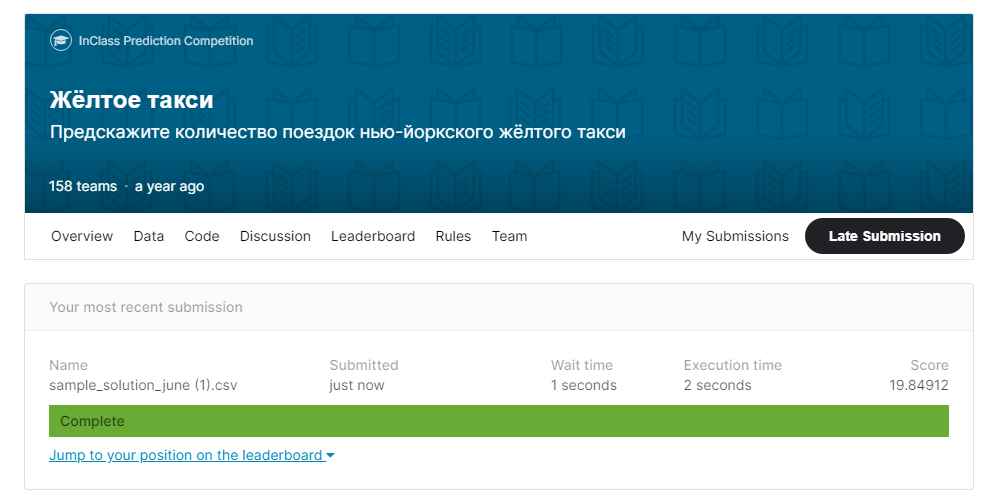